### **Previsão de Trajetória usando Redes Neurais**

Esse projeto tem o objetivo de criar um modelo de redes neurais capaz de, dado um cenário bidimensional com:
- Uma posição objetivo ($x$,$y$) (m,m) no espaço;

Queremos prever valores de:
- Velocidade ($v$) (m/s);
- Direção ($\theta$) (°);
- Tempo ($t$) (s);

De modo que ao lançar um projétil:
- Partindo da posição ($0$,$0$);
- Com um ângulo $\theta$;
- Com velocidade inicial $v$;

O projétil alcançará a posição ($x$,$y$) no tempo $t$.

#### **Seção 0** - Importações

Serão utilizadas nesse modelo as bibliotecas
- PyTorch e NumPy para representar e tratar tensores e vetores;
- MatPlotLib para criar gráficos ilustrando trajetórias;
- Time para registar tempo de treinamento;

In [10]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import time

Em seguida, também criamos alguns dicionários determinando parâmetros do nosso modelo de simulação:

In [11]:
# Valores Padrão dos Hiperparâmetros - Modelo de Exemplo
DEF_nodes = 96
DEF_minSpeed = 1
DEF_maxSpeed = 20
DEF_minTime = 1
DEF_maxTime = 10
DEF_learningRate = 1e-4
DEF_pointsPerLoss = 1024
DEF_epochs = 15000
DEF_angle = torch.pi*2
DEF_gravity = 9.81

In [12]:
example_model = {
    'identifier': 'example',
    'nodes': DEF_nodes,
    'minSpeed': DEF_minSpeed,
    'maxSpeed': DEF_maxSpeed,
    'minTime': DEF_minTime,
    'maxTime': DEF_maxTime,
    'learningRate': DEF_learningRate,
    'pointsPerLoss': DEF_pointsPerLoss,
    'epochs': DEF_epochs,
    'angle': DEF_angle,
    'gravity': DEF_gravity
}

longer_model = {
    'identifier': 'longer',
    'nodes': DEF_nodes,
    'minSpeed': DEF_minSpeed,
    'maxSpeed': DEF_maxSpeed,
    'minTime': DEF_minTime,
    'maxTime': DEF_maxTime,
    'learningRate': DEF_learningRate,
    'pointsPerLoss': DEF_pointsPerLoss,
    'epochs': 50000,
    'angle': DEF_angle,
    'gravity': DEF_gravity
}

selected_model = example_model

#### **Seção 1** - Classe do Modelo

Essa seção descreve o modelo TripleReluModel utilizado para a rede neural. Nessa classe, serão recebidos os hiperparâmetros `nodes` correspondente ao número de nós por camada, `minSpeed` e `maxSpeed` correspondentes aos valores mínimo e máximo de velocidade considerados e `minTime`, `maxTime` correspondentes ao intervalo de tempo mínimo e máximo aceitáveis.

Esses hiperparâmetros existem tanto para possibilitar fáceis modificações no modelo quanto para evitar casos degenerados que podem levar para pontos problemáticos do espaço paramétrico, incluindo:
- Tempo de alcance excessivamente próximo de zero;
- Tempo de alcance excessivamente grande;
- Velocidade excessivamente próxima de zero;

O modelo é composto pela seguinte estutura de camadas:
- `Input` $\times$ 2 $\rightarrow$ ReLU(`Linear` $\times$ nodes)$^3$ $\rightarrow$ `Output` $\times$ 3

In [13]:
class TripleReluModel(nn.Module):
    def __init__(self, nodes, minSpeed, maxSpeed, minTime, maxTime, angle):
        super().__init__()
        self.minSpeed = minSpeed
        self.maxSpeed = maxSpeed
        self.minTime = minTime
        self.maxTime = maxTime
        self.angle = angle
        self.network = nn.Sequential(
            nn.Linear(2, nodes),
            nn.ReLU(),
            nn.Linear(nodes, nodes),
            nn.ReLU(),
            nn.Linear(nodes, nodes),
            nn.ReLU(),
            nn.Linear(nodes, 3)
        )
        
    def forward(self, xy):
        params = self.network(xy)
        v = self.minSpeed + nn.functional.sigmoid(params[:, 0:1])*(self.maxSpeed - self.minSpeed)
        theta = torch.sigmoid(params[:, 1:2]) * self.angle
        t = self.minTime + torch.sigmoid(params[:, 2:3])*(self.maxTime - self.minTime)
        return v, theta, t

#### **Seção 2** - Classe do Solver

Essa seção descreve a classe principal do projeto, o solver LaunchPredictor. O solver que será descrito apresenta os seguintes hiperparâmetros:

- `nodes`, `minSpeed`, `maxSpeed`, `minTime`, `maxTime` usados na classe do modelo;

- `learningRate` descrevendo a taxa de aprendizado utilizada;

- `pointsPerLoss` representando o número de amostras usado em cada cálculo da função de perda;

- `gravity` representando a aceleração da gravidade.

Dados os hiperparâmetros, criamos as funções
- **_ _ init _ _**: Cria o modelo e guarda os valores dos hiperparâmetros. Também inicializa um histórico de perdas, placeholders para a perda e um valor de viés, representando uma constante de suavização para evitar eventuais problemas com distância próxima de zero do corpo gravitacional.

- **show_current_state**: Mostra o estado atual do treino modelo dada a época e percentual de treino já completo.

- **calculate_loss**: Gera pontos aleatórios em uma região dentro da distância definida pelo hiperparâmetro, utiliza os pesos atuais da rede neural para simular lançamentos pela expressão analítica da trajetória e calcula a perda do modelo, que é calculada como a média do quadrado das distâncias de cada lançamento.

- **fit**: Função que realiza o treinamento do modelo. Para o número definido de épocas, faz seções de treinamento que consistem em um procedimento comum de machine learning, com os detalhes únicos desse modelo sendo o uso de simulações diferenciais para encontrar a perda de uma trajetória.

- **predict**: Função que realiza a predição dos valores desejados dada uma lista de posições do ponto objetivo e retorna uma lista de objetos descrevendo cada predição de forma adequada.

- **get_trajectory**: Retorna os pontos de uma trajetória dados os parâmetros $v$,$\theta$,$t$ utilizados nela.

- **plot_loss**: Faz um gráfico que compara a função de perda ao decorrer das épocas durante a etapa de treinamento.

- **plot_predictions**: Dada uma lista de predições, faz o plot dessas predições, ilustrando a trajetória dos objetos de cada predição.

- **save_state**: Salva o estado treinado do modelo atualmente para evitar múltiplos treinos e preservar resultados.

- **load_state**: Carrega um estado previamente salvo pelo modelo.

- **generate_random_points**: Gera novos pontos aleatórios para etapa de teste.

- **evaluate**: Executa uma etapa de teste do modelo, calculando algumas estatísticas e exibindo plots visuais das predições.

In [14]:
class LaunchPredictor:
    def __init__(self,  identifier, load = False, nodes = DEF_nodes, minSpeed = DEF_minSpeed, maxSpeed = DEF_maxSpeed, minTime = DEF_minTime, maxTime = DEF_maxTime, learningRate = DEF_learningRate, pointsPerLoss = DEF_pointsPerLoss, epochs = DEF_epochs, angle = DEF_angle, gravity = DEF_gravity):
        
        self.identifier = identifier
        self.nodes = nodes
        self.minSpeed = minSpeed
        self.maxSpeed = maxSpeed
        self.minTime = minTime
        self.maxTime = maxTime
        self.learningRate = learningRate
        self.pointsPerLoss = pointsPerLoss
        self.epochs = epochs
        self.angle = angle
        self.gravity = gravity
        
        self.LimX = [0, (self.maxSpeed)**2 / 20]
        self.LimY = [0, (self.maxSpeed)**2 / 30]
        
        self.loss = None
        self.lossValue = torch.tensor(0.0)
        self.lossHistory = []
        self.bias = 1
    
        self.model = TripleReluModel(nodes, minSpeed, maxSpeed, minTime, maxTime, angle)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learningRate)
        
        if load:
            load_status = self.load_state() 
            if not load_status.startswith("S"):
                print(f"Falha ao carregar o modelo: {load_status}. Iniciando um novo modelo.")
    
    def show_current_state(self, epoch, percent):
        statusString = f"Epoch: {epoch} ({percent:.1f}%)"
        print(f"{statusString:<25} |   Loss: {self.lossValue.item():.6f}")
        
    def calculate_loss(self):
        xi = torch.rand(self.pointsPerLoss, 1) * (self.LimX[1] - self.LimX[0]) + self.LimX[0]
        yi = torch.rand(self.pointsPerLoss, 1) * (self.LimY[1] - self.LimY[0]) + self.LimY[0]
        xy = torch.cat([xi, yi], dim=1)
        
        v_pred, theta_pred, t_final_pred = self.model(xy)
        
        x = v_pred * torch.cos(theta_pred) * t_final_pred
        y = v_pred * torch.sin(theta_pred) * t_final_pred - 0.5 * self.gravity * t_final_pred**2
        
        losses_tensor = (xi - x)**2 + (yi - y)**2
        self.loss = torch.mean(losses_tensor)
        self.lossValue = self.loss.detach()
                
    def fit(self, epochs = None, silent = False):
        if epochs is None:
            epochs = self.epochs
            
        self.model.train()
        print(f"Iniciando treino com {epochs} épocas.")
        t0 = time.time()
        
        for epoch in range(1, epochs + 1):
            self.calculate_loss()
            self.optimizer.zero_grad()
            
            if torch.isnan(self.loss):
                continue
            
            self.loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()
            self.lossHistory.append(self.lossValue.item())
            
            if (epoch % 500 == 0 or epoch == epochs) and not silent:
                self.show_current_state(epoch,(epoch/epochs)*100)
                
        tn = time.time()
        
        def convert_time(timeSpent):
            total_sec = np.floor(timeSpent)
            total_mins, z = divmod(total_sec, 60)
            x, y = divmod(total_mins, 60)
            
            t1 = "" if x == 0 else f'{x} hora' + ('s ' if x > 1 else ' ')
            t2 = "" if y == 0 else f'{y} minuto' + ('s ' if y > 1 else ' ')
            t3 = "" if z == 0 else f'{z} segundo' + ('s ' if z > 1 else ' ')
            
            return f"{t1}{t2}{t3}"
        
        print(f"Treino finalizado em {convert_time(tn-t0)}.")
        
    def predict(self, x_test):
        self.model.eval()
        x_tensor = torch.tensor(x_test, dtype=torch.float32)
        
        with torch.no_grad():
            v_pred, th_pred, t_final_pred = self.model(x_tensor)
        
        predictions = []
        for i, (xt, yt) in enumerate(x_test):
            predictions.append({
                "target": (xt, yt),
                "v": v_pred[i].item(),
                "theta": th_pred[i].item(),
                "t_final": t_final_pred[i].item()
            })
        return predictions
    
    def get_trajectory(self, v, th, t):
        t_plot = np.linspace(0, t, 200)
        x_traj = v * np.cos(th) * t_plot
        y_traj = v * np.sin(th) * t_plot - 0.5 * self.gravity * t_plot**2
        return np.vstack([x_traj, y_traj]).T
    
    def plot_loss(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.lossHistory)
        plt.title('Histórico de Perda (Loss) do Treinamento')
        plt.xlabel('Época (Epoch)')
        plt.ylabel('Loss (Log Scale)')
        plt.yscale('log')
        plt.grid(True, which="both", ls="--", alpha=0.5)
        plt.show()
                
    def plot_predictions(self, predictions):
        plt.figure(figsize=(12, 8))
        colors = plt.cm.viridis(np.linspace(0, 1, len(predictions)))
        for i, pred in enumerate(predictions):
            xt, yt = pred["target"]
            v_p, th_p, tf_p = pred["v"], pred["theta"], pred["t_final"]

            t_plot = np.linspace(0, tf_p, 100)
            x_traj = v_p * np.cos(th_p) * t_plot
            y_traj = v_p * np.sin(th_p) * t_plot - 0.5 * self.gravity * t_plot**2
            plt.plot(x_traj, y_traj, color=colors[i], linestyle='-', label=f'PINN for {pred["target"]}')
            
            plt.scatter([xt], [yt], color=colors[i], s=100, zorder=5, marker='x')
        
        plt.scatter([0], [0], color='black', s=150, zorder=6, label='Start (0,0)')
        plt.title(f'Previsões do Modelo')
        plt.xlabel('Posição X')
        plt.ylabel('Posição Y')
        plt.grid(True)
        plt.axhline(0, color='grey', linewidth=0.5)
        plt.axvline(0, color='grey', linewidth=0.5)
        plt.axis('equal')
        plt.show()
        
    def save_state(self):
        filepath = f'./models/basic/{self.identifier}.pth'
        
        state = state = {
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'loss_history': self.lossHistory,

            'identifier': self.identifier,
            'nodes': self.nodes,
            'minSpeed': self.minSpeed,
            'maxSpeed': self.maxSpeed,
            'minTime': self.minTime,
            'maxTime': self.maxTime,
            'learningRate': self.learningRate,
            'pointsPerLoss': self.pointsPerLoss,
            'epochs': self.epochs,
            'angle': self.angle,
            'gravity': self.gravity
        }
        
        torch.save(state, filepath)
        print(f"Modelo {self.identifier} salvo com sucesso em: '{filepath}'")

    def load_state(self):
        try:
            filepath = f'./models/basic/{self.identifier}.pth'
            savepoint = torch.load(filepath)
            savepoint['angle'] = self.angle
            
            self.model.load_state_dict(savepoint['model_state_dict'])
            self.optimizer.load_state_dict(savepoint['optimizer_state_dict'])
            self.lossHistory = savepoint['loss_history']
            
            self.nodes = savepoint['nodes']
            self.minSpeed = savepoint['minSpeed']
            self.maxSpeed = savepoint['maxSpeed']
            self.minTime = savepoint['minTime']
            self.maxTime = savepoint['maxTime']
            self.learningRate = savepoint['learningRate']
            self.pointsPerLoss = savepoint['pointsPerLoss']
            self.epochs = savepoint['epochs']
            self.angle = savepoint['angle']
            self.gravity = savepoint['gravity']
            
            self.model.eval()
            
            print(f"Modelo {self.identifier} carregado com sucesso de: '{filepath}'")
            if self.lossHistory:
                self.lossValue = torch.tensor(self.lossHistory[-1])
            return "S"
        except FileNotFoundError:
            return "N-File Not Found"
        except Exception as e:
            return f"E-{e}"
        
    def generate_random_points(self, N):
        x_target = torch.rand(N, 1) * (self.LimX[1] - self.LimX[0]) + self.LimX[0]
        y_target = torch.rand(N, 1) * (self.LimY[1] - self.LimY[0]) + self.LimY[0]
        return np.hstack([x_target, y_target])

    def evaluate(self, N):
        x_k = self.generate_random_points(N)
        preds = self.predict(x_k)
        self.plot_predictions(preds)

        all_errors = []
        for pred in preds:
            v = pred["v"]
            th = pred["theta"]
            t = pred["t_final"]
            target_pos = pred["target"]

            traj = self.get_trajectory(v, th, t)
            final_pos = traj[-1]
            
            error_dist = np.sqrt((final_pos[0] - target_pos[0])**2 + (final_pos[1] - target_pos[1])**2)
            all_errors.append(error_dist)
            
        errors_np = np.array(all_errors)
        mse = np.mean(np.square(errors_np))
        mean_error = np.mean(errors_np)
        min_error = np.min(errors_np)
        max_error = np.max(errors_np)
        median_error = np.median(errors_np)

        print(f"Erro Quadrático Médio (MSE): {mse:.4f}")
        print(f"Erro Médio:                 {mean_error:.4f}")
        print(f"Erro Mediano:               {median_error:.4f}")
        print(f"Erro Mínimo:                {min_error:.4f}")
        print(f"Erro Máximo:                {max_error:.4f}")

#### **Seção 3** - Treinamento

Nessa seção, criaremos uma instância simples do problema e o treinaremos. Considerando uma gravidade de 9.81 $m/s^2$, precisamos lançar um objeto de modo que ele acerte o seu alvo sem restrições quanto a direção, mas com uma velocidade mínima de 1 $m/s$ e máxima de 20 $m/s$ em um tempo de 1 até 10 $s$.

In [15]:
solver = LaunchPredictor(
    identifier = selected_model['identifier'],
    nodes = selected_model['nodes'],
    minSpeed = selected_model['minSpeed'],
    maxSpeed = selected_model['maxSpeed'],
    minTime = selected_model['minTime'],
    maxTime = selected_model['maxTime'],
    learningRate = selected_model['learningRate'],
    pointsPerLoss = selected_model['pointsPerLoss'],
    epochs = selected_model['epochs'],
    angle = selected_model['angle'],
    gravity = selected_model['gravity']
)

Agora, executamos o treinamento, se já não estiver salvo.

In [16]:
tryLoad = solver.load_state()
if tryLoad[0] != 'S':
    solver.fit()

Modelo example carregado com sucesso de: './models/basic/example.pth'


#### **Seção 4** - Avaliação

Por fim, faremos uma avaliação rápida do nosso modelo, para entender se ele se aproximou bem o bastante dos pontos novos propostos. Geraremos 60 pontos novos dentro da mesma região proposta nos hiperparâmetros e chamaremos a função de predição e plotagem com esses pontos. Também calcularemos estatísticas do nosso erro, como MSE, erro mínimo, erro máximo e mediana dos erros para entender melhor sua distribuição.


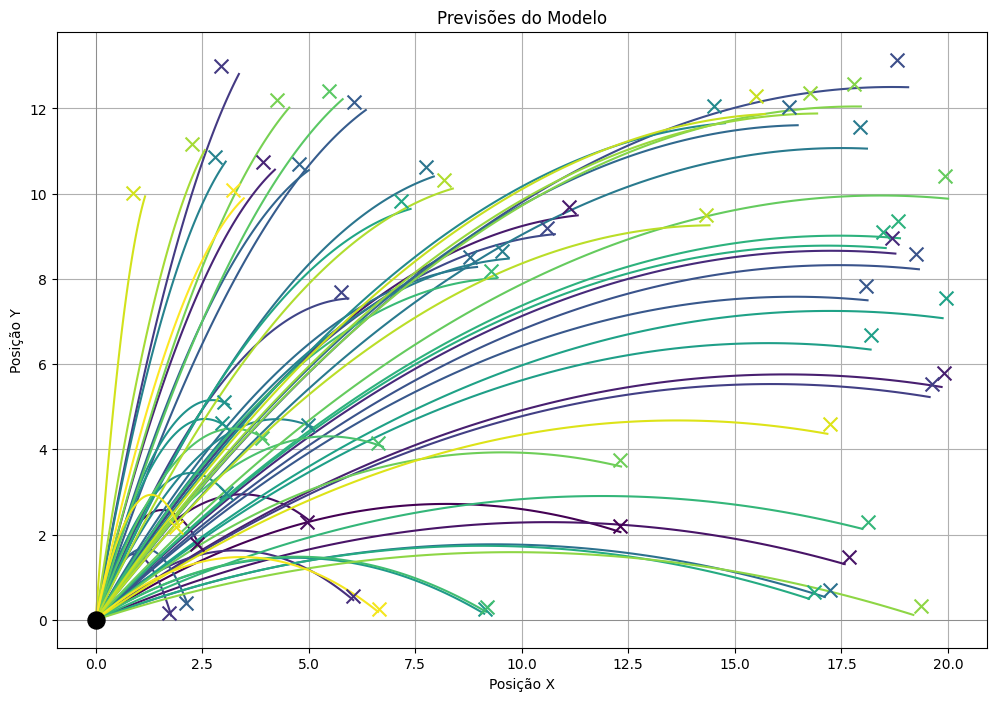

Erro Quadrático Médio (MSE): 0.0981
Erro Médio:                 0.2775
Erro Mediano:               0.2838
Erro Mínimo:                0.0419
Erro Máximo:                0.6926


In [17]:
solver.evaluate(60)

Por fim, podemos salvar nossos resultados na ocasião de termos treinado um novo modelo:

In [18]:
if tryLoad[0] != 'S':
    solver.save_state()